In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from datetime import date, datetime, timedelta
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import fcluster
from matplotlib.colors import TwoSlopeNorm

# parameter

In [2]:
yeari, yearf = '2024', '2024'
weeki, weekf = '18', '31'

In [3]:
di = datetime.strptime(f'{yeari}-{weeki}-1', "%Y-%W-%w").date()
df = datetime.strptime(f'{yearf}-{weekf}-1', "%Y-%W-%w").date() + timedelta(6)
ds = [di+timedelta(dt) for dt in range((df-di).days+1)]
daylist = ds
print(di, 'until', df)

2024-04-29 until 2024-08-04


In [4]:
cdef = 'tl7_10m'# 'tl5_10m' 'tl6_10m' 'tl7_10m' 'tl8_10m' 'tl8_60m'
cdef_alt = '16m_10min'# tl5: 62 ... tl7: 16   tl8: 8

# figures & tables

In [5]:
data_osm2 = pd.read_csv('data/fig5/contacts_matchdays_osmmapped.csv', low_memory=False)
data_osmpoint2 = pd.read_csv('data/fig5/contacts_matchdays_osmpointmapped2.csv', low_memory=False)
data_hw2 = pd.read_csv('data/fig5/contacts_matchdays_homework.csv', low_memory=False).rename(columns={'is_home':'home','is_work':'work'})
data_hw2['home'] = data_hw2.home.map({True:'yes',False:'no'})
data_hw2['work'] = data_hw2.work.map({True:'yes',False:'no'})
print('data_osm2', len(data_osm2), len(data_osm2.columns))
print('data_osmpoint2', len(data_osmpoint2), len(data_osmpoint2.columns))
print('data_hw2', len(data_hw2), len(data_hw2.columns))

data_osm2 119816 74
data_osmpoint2 87981 11
data_hw2 31489 7


In [6]:
data_osm2 = data_osm2[data_osm2.city.isin(['Stuttgart','Frankfurt am Main','Dortmund','München'])]
data_osmpoint2 = data_osmpoint2[data_osmpoint2.city.isin(['Stuttgart','Frankfurt am Main','Dortmund','München'])]
data_hw2 = data_hw2[data_hw2.city.isin(['Stuttgart','Frankfurt am Main','Dortmund','München'])]
print('data_osm2', len(data_osm2), len(data_osm2.columns))
print('data_osmpoint2', len(data_osmpoint2), len(data_osmpoint2.columns))
print('data_hw2', len(data_hw2), len(data_hw2.columns))

data_osm2 36135 74
data_osmpoint2 27155 11
data_hw2 7477 7


In [7]:
data_osm2_bef = data_osm2[(data_osm2.hour_rel.isin([-2,-1]))].copy() # [(data_osm2.hour_rel < 0)].copy() [(data_osm2.hour_rel.isin([-2,-1]))].copy()
data_osm2_bef['match_rel'] = 'before match'
data_osm2_dur = data_osm2[(data_osm2.hour_rel.isin([0,1]))].copy()
data_osm2_dur['match_rel'] = 'during match'
data_osm2_aft = data_osm2[(data_osm2.hour_rel.isin([2,3]))].copy() # [(data_osm2.hour_rel > 1)].copy() [(data_osm2.hour_rel.isin([2,3]))].copy()
data_osm2_aft['match_rel'] = 'after match'
data_osm2_all = data_osm2.copy()
data_osm2_all['match_rel'] = 'day of the match'
data_osm2 = pd.concat([data_osm2_bef, data_osm2_dur, data_osm2_aft])#, data_osm2_all])

data_osmpoint2_bef = data_osmpoint2[(data_osmpoint2.hour_rel.isin([-2,-1]))].copy() # [(data_osmpoint2.hour_rel < 0)].copy() [(data_osmpoint2.hour_rel.isin([-2,-1]))].copy()
data_osmpoint2_bef['match_rel'] = 'before match'
data_osmpoint2_dur = data_osmpoint2[(data_osmpoint2.hour_rel.isin([0,1]))].copy()
data_osmpoint2_dur['match_rel'] = 'during match'
data_osmpoint2_aft = data_osmpoint2[(data_osmpoint2.hour_rel.isin([2,3]))].copy() # [(data_osmpoint2.hour_rel > 1)].copy() [(data_osmpoint2.hour_rel.isin([2,3]))].copy()
data_osmpoint2_aft['match_rel'] = 'after match'
data_osmpoint2_all = data_osmpoint2.copy()
data_osmpoint2_all['match_rel'] = 'day of the match'
data_osmpoint2 = pd.concat([data_osmpoint2_bef, data_osmpoint2_dur, data_osmpoint2_aft])#, data_osmpoint2_all])

data_hw2_bef = data_hw2[(data_hw2.hour_rel.isin([-2,-1]))].copy()
data_hw2_bef['match_rel'] = 'before match'
data_hw2_dur = data_hw2[(data_hw2.hour_rel.isin([0,1]))].copy()
data_hw2_dur['match_rel'] = 'during match'
data_hw2_aft = data_hw2[(data_hw2.hour_rel.isin([2,3]))].copy()
data_hw2_aft['match_rel'] = 'after match'
data_hw2_all = data_hw2.copy()
data_hw2_all['match_rel'] = 'day of the match'
data_hw2 = pd.concat([data_hw2_bef, data_hw2_dur, data_hw2_aft])#, data_hw2_all])

print(len(data_osm2))
print(len(data_osmpoint2))
print(len(data_hw2))

12299
7382
2674


In [8]:
df_norm_bytime = data_osm2.groupby(['germany','match_rel']).apply(len).reset_index().rename(columns={0:'norm'})
df_norm_bytime

,germany,match_rel,norm
0,False,after match,2598
1,False,before match,4276
2,False,during match,2205
3,True,after match,569
4,True,before match,2025
5,True,during match,626


In [9]:
df_norm = data_osm2.groupby(['germany']).apply(len).reset_index().rename(columns={0:'norm'})
df_norm

,germany,norm
0,False,9079
1,True,3220


In [10]:
attr_freq = pd.DataFrame()
excl = ['germany','match_rel','city','hour_rel','osm_id','osm_id.1','plz','tile_id','tile_id.1','tl','z_order','osm_id_point']
for attr in [col for col in data_osm2.columns if col not in excl]:
    df_cnt = data_osm2.groupby(['germany','match_rel'])[attr].apply(lambda x: (~x.isna()).sum()).reset_index()\
                .merge(df_norm_bytime, on=['germany','match_rel'])
    df_cnt['freq'] = df_cnt[attr] / df_cnt.norm
    df_cnt['attr'] = attr
    attr_freq = pd.concat([attr_freq, df_cnt[['germany','match_rel','attr','freq']]])
for attr in [col for col in data_osmpoint2.columns if col not in excl]:
    df_cnt = data_osmpoint2.groupby(['germany','match_rel'])[attr].apply(lambda x: (~x.isna()).sum()).reset_index()\
                .merge(df_norm_bytime, on=['germany','match_rel'])
    df_cnt['freq'] = df_cnt[attr] / df_cnt.norm
    df_cnt['attr'] = attr
    attr_freq = pd.concat([attr_freq, df_cnt[['germany','match_rel','attr','freq']]])
for attr in [col for col in data_hw2.columns if col not in excl]:
    df_cnt = data_hw2.groupby(['germany','match_rel'])[attr].apply(lambda x: (~x.isna()).sum()).reset_index()\
                .merge(df_norm_bytime, on=['germany','match_rel'])
    df_cnt['freq'] = df_cnt[attr] / df_cnt.norm
    df_cnt['attr'] = attr
    attr_freq = pd.concat([attr_freq, df_cnt[['germany','match_rel','attr','freq']]])
attr_freq['germany'] = attr_freq.germany.astype(str)
attr_freq#.groupby(['germany','match_rel']).freq.apply(np.sum).reset_index()

,germany,match_rel,attr,freq
0,False,after match,man_made,0.004619
1,False,before match,man_made,0.010056
2,False,during match,man_made,0.005442
3,True,after match,man_made,0.008787
4,True,before match,man_made,0.004444
...,...,...,...,...
1,False,before match,work,0.228485
2,False,during match,work,0.232200
3,True,after match,work,0.170475
4,True,before match,work,0.260247


In [11]:
attr_freq_toplot = attr_freq.copy(deep=True)
attr_freq_toplot['attr'] = [at if '_point' not in at else '*'+at[:-6] for at in attr_freq_toplot.attr]
attr_freq_toplot

,germany,match_rel,attr,freq
0,False,after match,man_made,0.004619
1,False,before match,man_made,0.010056
2,False,during match,man_made,0.005442
3,True,after match,man_made,0.008787
4,True,before match,man_made,0.004444
...,...,...,...,...
1,False,before match,work,0.228485
2,False,during match,work,0.232200
3,True,after match,work,0.170475
4,True,before match,work,0.260247


C:\Users\steven.schulz\AppData\Local\Temp\ipykernel_13096\455294856.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.axes.flat[-1].set_xticklabels(g.axes.flat[-1].get_xticklabels(), rotation=90)


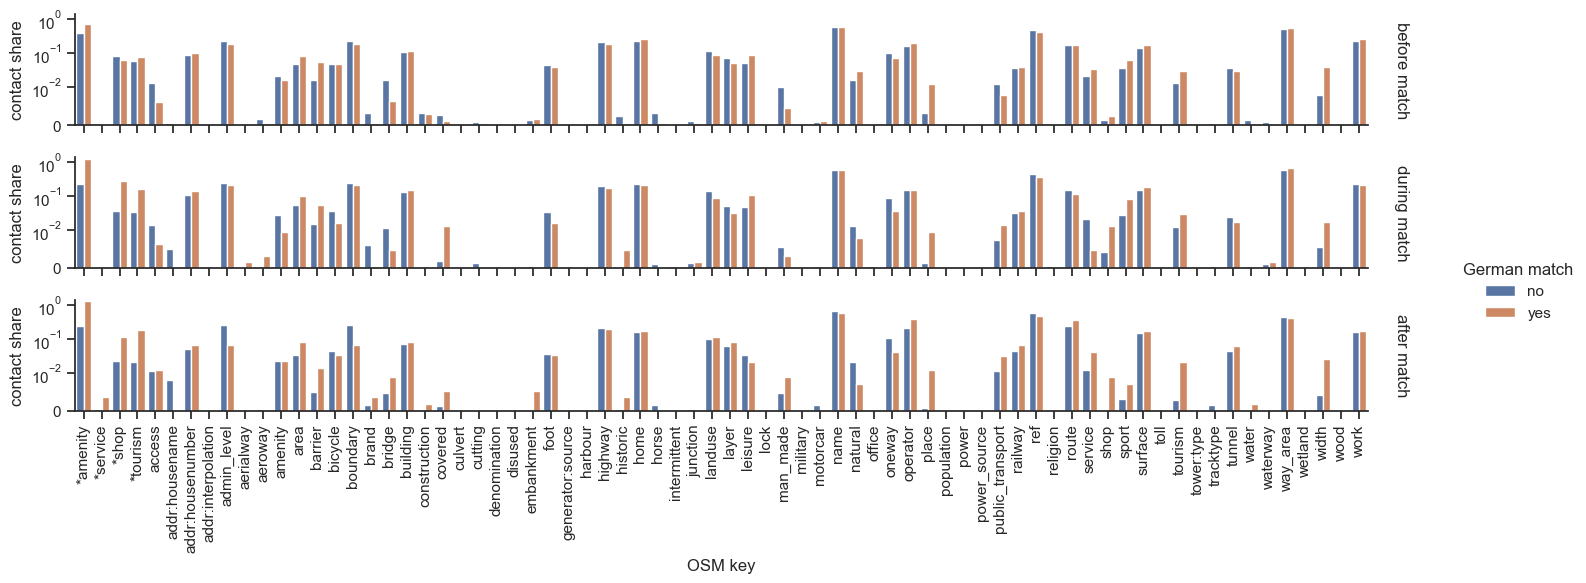

In [13]:
sns.set_theme(style="ticks")

# Create a FacetGrid, grouping by 'category'
g = sns.FacetGrid(attr_freq_toplot.sort_values(['attr','germany']),
                  row='match_rel', margin_titles=True, height=2, aspect=7.5,
                  row_order=['before match','during match','after match'],
                  legend_out=True,)#,'day of the match'])

# Map the custom heatmap function to each facet
g.map_dataframe(sns.barplot, x='attr', y='freq', hue='germany', palette=sns.color_palette(None, 2))

# Set yticks for all subplots
g.set(xlabel='OSM key', ylabel='contact share')#, yticks=[])
#g.set_yticklabels([], rotation=0)
#g.set_xticklabels([], rotation=0)

for ax in g.axes.flat:
    ax.set_yscale('symlog', linthresh=.01)

# Modify margin titles
g.set_titles(row_template="{row_name}")#, size=14, fontweight='bold')
g.axes.flat[-1].set_xticklabels(g.axes.flat[-1].get_xticklabels(), rotation=90)

# legend
g.add_legend()
lg = g._legend
lg.set_title('German match')
for tx in lg.texts:
    if tx.get_text() == 'False':
        tx.set_text('no')
    elif tx.get_text() == 'True':
        tx.set_text('yes')

g.tight_layout()
plt.show()

In [14]:
attr2vals = {
    'aeroway':['terminal'],
    'amenity':['parking','biergarten','full','nightclub','police','pub','restaurant','shelter','marketplace'],
    'area':['yes'],
    'barrier':['fence','bollard','wall'],
    'bicycle':['yes'],
    'building':['yes','train_station','stadium','roof','retail','grandstand'],
    'foot':['yes','no','permissive','designated'],
    'highway':['primary','secondary','tertiary','pedestrian','motorway','footway','cycleway','service'],
    'landuse':['residential','retail','railway','commercial'],
    'leisure':['stadium','pitch','park'],
    'oneway':['yes'],
    'railway':['light_rail','platform','rail','subway','tram'],
    'route':['tram','train','subway','road','light_rail','bus','bicycle'],
    'service':['tourism','event','driveway','commuter'],
    'shop':['supermarket','mall'],
    'sport':['soccer'],
    'surface':['paving stones','paved','grass','fine_gravel','asphalt','sett'],
    'tourism':['attraction','museum'],
}
attr2vals_point = {
    'amenity_point':['atm','bank','bar','bench','bicycle_rental','cafe','community_centre','drinking_water','fast_food',
                     'locker','lounge','parking_entrance','police','pub','restaurant','taxi','telephone','toilets',
                     'vending_machine','waste_basket'],
    'shop_point':[v for v in set(data_osmpoint2[~data_osmpoint2.shop_point.isna()].shop_point)],
    'shop_bool_point':['yes'],
    'tourism_point':['artwork','hotel','information','museum','viewpoint'],
}
attr2vals_hw = {
    'home':['yes'],
    'work':['yes'],
}

####### not actually used anymore for the results
cl2attrs = {
    'street commute':['amenity:parking',\
              'highway:motorway','highway:primary','highway:secondary','highway:service','highway:tertiary',\
              'oneway:yes','route:bicycle',\
              'route:road','surface:asphalt',
              'amenity_point:parking_entrance',],
    #'aeroway:terminal','bicycle:yes','highway:cycleway','service:driveway','route:bus',
    'rail commute':['railway:platform','railway:rail',\
                    'route:light_rail','route:train','route:tram','service:commuter',
                    'amenity_point:bicycle_rental'],
    #'railway:light_rail','route:subway','building:train_station','railway:subway','railway:tram',
    'non-stadium':['landuse:residential',\
                 'area:yes','building:retail','building:roof','building:yes',\
                 'landuse:commercial','landuse:retail','leisure:park','service:event','service:tourism',\
                 'shop:mall','surface:fine_gravel','surface:grass','surface:paved',\
                 'highway:footway','highway:pedestrian',
                 'tourism:attraction',
                 'amenity_point:atm','amenity_point:bank','amenity_point:bench','amenity_point:cafe',
                 'amenity_point:drinking_water','amenity_point:fast_food','amenity_point:locker','amenity_point:lounge',
                 'amenity_point:police','amenity_point:restaurant','amenity_point:taxi',
                 'amenity_point:telephone','amenity_point:toilet','amenity_point:vending_machine','amenity_point:waste_basket',
                 'shop_bool_point:yes',
                 'tourism_point:artwork','tourism_point:hotel','tourism_point:information','tourism_point:museum','tourism_point:viewpoint'],
    #'amenity:marketplace','amenity:restaurant','foot:designated','foot:no','foot:permissive','foot:yes','landuse:railway','surface:sett',
    #'tourism:museum'
    #'amenity:nightclub','amenity:police','amenity:pub','amenity_point:pub','amenity_point:community_centre','shop:supermarket','amenity:biergarten',
    'stadium':['building:grandstand','building:stadium','sport:soccer','leisure:pitch','leisure:stadium',\
                 'barrier:fence','barrier:wall',],
    #'barrier:bollard',
    #'ignoring':['tourism:attraction','tourism:museum'],
    #'other':['amenity:shelter'],
    'else':['home:yes','work:yes'],
}
attr2cl = {attr: cl for cl, attrs in cl2attrs.items() for attr in attrs}

In [15]:
cat_freq = pd.DataFrame()
data_osmpoint2['shop_bool_point'] = (~data_osmpoint2.shop_point.isna()).astype(str).map({'True':'yes','False':'no'})
for attr, vals in attr2vals.items():
    df_cnt = data_osm2.groupby(['germany','match_rel',attr]).apply(lambda x: len(x)).reset_index()\
                    .rename(columns={0:'cnt', attr:'cat'}).merge(df_norm, on=['germany'])#'match_rel','germany'
    df_cnt = df_cnt[df_cnt.cat.isin(vals)]
    df_cnt['cat'] = [attr+':'+c for c in df_cnt.cat]
    cat_freq = pd.concat([cat_freq, df_cnt])
for attr, vals in attr2vals_point.items():
    df_cnt = data_osmpoint2.groupby(['germany','match_rel',attr]).apply(lambda x: len(x)).reset_index()\
                    .rename(columns={0:'cnt', attr:'cat'}).merge(df_norm, on=['germany'])#'match_rel','germany'
    df_cnt = df_cnt[df_cnt.cat.isin(vals)]
    df_cnt['cat'] = [attr+':'+c for c in df_cnt.cat]
    cat_freq = pd.concat([cat_freq, df_cnt])
for attr, vals in attr2vals_hw.items():
    df_cnt = data_hw2.groupby(['germany','match_rel',attr]).apply(lambda x: len(x)).reset_index()\
                    .rename(columns={0:'cnt', attr:'cat'}).merge(df_norm, on=['germany'])#'match_rel','germany'
    df_cnt = df_cnt[df_cnt.cat.isin(vals)]
    df_cnt['cat'] = [attr+':'+c for c in df_cnt.cat]
    cat_freq = pd.concat([cat_freq, df_cnt])
cat_freq['freq'] = cat_freq.cnt / cat_freq.norm
cat_freq['germany'] = cat_freq.germany.astype(str)
#cat_freq['cl'] = cat_freq.cat.map(attr2cl)
cat_freq['cat_label'] = cat_freq.cat.apply(lambda x: ':'.join([word if '_point' not in word else '*'+word[:-6] for word in x.split(':')]))
cat_freq

,germany,match_rel,cat,cnt,norm,freq,cat_label
0,False,after match,aeroway:terminal,1,9079,0.000110,aeroway:terminal
2,False,before match,aeroway:terminal,5,9079,0.000551,aeroway:terminal
3,True,before match,aeroway:terminal,1,3220,0.000311,aeroway:terminal
4,True,during match,aeroway:terminal,2,3220,0.000621,aeroway:terminal
2,False,after match,amenity:biergarten,6,9079,0.000661,amenity:biergarten
...,...,...,...,...,...,...,...
3,False,before match,work:yes,49,9079,0.005397,work:yes
5,False,during match,work:yes,29,9079,0.003194,work:yes
7,True,after match,work:yes,5,3220,0.001553,work:yes
9,True,before match,work:yes,16,3220,0.004969,work:yes


In [16]:
cat_freq.groupby(['germany']).cnt.sum()

germany
False    12264
True      7397
Name: cnt, dtype: int64

In [17]:
len(set(cat_freq[cat_freq.match_rel!='day of the match'].cat_label))

150

In [18]:
# gather data for clustering of map features
to_cluster = cat_freq[(cat_freq.match_rel!='day of the match') & (cat_freq.cat_label!='*shop_bool:yes')][['germany','match_rel','cat_label','freq']]
#'cnt','norm',
# if necessary: remove map features with too few contacts
to_cluster15 = to_cluster.groupby('cat_label').freq.apply(np.sum).reset_index()
cats_restr = to_cluster15[to_cluster15.freq >= 0*to_cluster15.freq.min()].sort_values('freq', ascending=False).cat_label.tolist()# 10*
#cats_restr = [cat for cat in cats_restr if not cat.startswith('*shop:') or cat=='*shop:yes']
print(f'leftover map features: {len(cats_restr)}')
# get data vector for each map feature
to_cluster2 = to_cluster[to_cluster.cat_label.isin(cats_restr)].pivot(index=['germany','match_rel'], columns='cat_label', values='freq').fillna(0)
# normalize the vectors
scaler = StandardScaler()
normalized = scaler.fit_transform(to_cluster2)
to_cluster3 = pd.DataFrame(normalized, index=to_cluster2.index, columns=to_cluster2.columns)
to_cluster3

leftover map features: 149


cat_label             *amenity:atm  *amenity:bank  *amenity:bar  \
germany match_rel                                                 
False   after match      -0.244411      -0.715536     -0.634380   
        before match      2.015369      -0.306514      0.419611   
        during match     -0.939728      -0.838243     -1.055977   
True    after match      -0.712742       0.158792     -1.161376   
        before match     -0.549368      -0.417839      1.216061   
        during match      0.430878       2.119340      1.216061   

cat_label             *amenity:bench  *amenity:bicycle_rental  *amenity:cafe  \
germany match_rel                                                              
False   after match        -0.853761                -0.044862      -0.998032   
        before match       -0.517645                -0.624234       0.842594   
        during match       -0.917507                -0.789768      -0.290099   
True    after match         0.082153                 2.003180      -1.448339   
        before match        2.030654                 0.369604       1.346150   
        during match        0.176106                -0.913919       0.547725   

cat_label             *amenity:community_centre  *amenity:drinking_water  \
germany match_rel                                                          
False   after match                    1.912763                -0.607264   
        before match                  -0.666243                 1.985415   
        during match                   0.752210                -0.842962   
True    after match                   -0.666243                -0.842962   
        before match                  -0.666243                -0.178396   
        during match                  -0.666243                 0.486170   

cat_label             *amenity:fast_food  *amenity:lounge  ...  \
germany match_rel                                          ...   
False   after match            -1.082596        -0.364627  ...   
        before match            1.128719        -0.420540  ...   
        during match           -1.441187        -0.867841  ...   
True    after match            -0.237112        -0.867841  ...   
        before match            0.605448         0.551003  ...   
        during match            1.026728         1.969846  ...   

cat_label             shop:supermarket  sport:soccer  surface:asphalt  \
germany match_rel                                                       
False   after match          -0.654654     -0.945588         0.075054   
        before match          0.654654      0.231970         0.900916   
        during match          1.963961     -0.500916        -0.419376   
True    after match          -0.654654     -0.918592        -1.058745   
        before match         -0.654654      1.983681         1.622174   
        during match         -0.654654      0.149444        -1.120023   

cat_label             surface:fine_gravel  surface:grass  surface:paved  \
germany match_rel                                                         
False   after match             -1.014640      -1.016049      -0.699081   
        before match            -0.908564       0.125542       0.410385   
        during match            -1.014640      -0.285431      -0.699081   
True    after match              0.779889      -1.024288      -1.377039   
        before match             1.378066       1.936998       0.898024   
        during match             0.779889       0.263228       1.466790   

cat_label             surface:sett  tourism:attraction  tourism:museum  \
germany match_rel                                                        
False   after match      -0.506761           -0.984059       -0.610754   
        before match     -0.177451           -0.025939        0.348655   
        during match     -0.753743           -0.562486       -0.610754   
True    after match      -0.603943           -0.412353       -0.610754   
        before match      2.181586            2.127042

In [19]:
cats = [s.split(':')[0] for s in to_cluster3.columns.tolist()]
clist = sns.husl_palette(len(set(cats)), s=1.)
cat2col = dict(zip(list(set(cats)), clist))
row_cols = pd.DataFrame(cats, index=to_cluster3.columns, columns=['cat_label']).cat_label.map(cat2col)

interesting clustering with deep hierarchies obtained with:

- average/complete, braycurtis
- complete, correlation/cosine/cityblock
- ward, euclidean

C:\Users\steven.schulz\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\steven.schulz\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


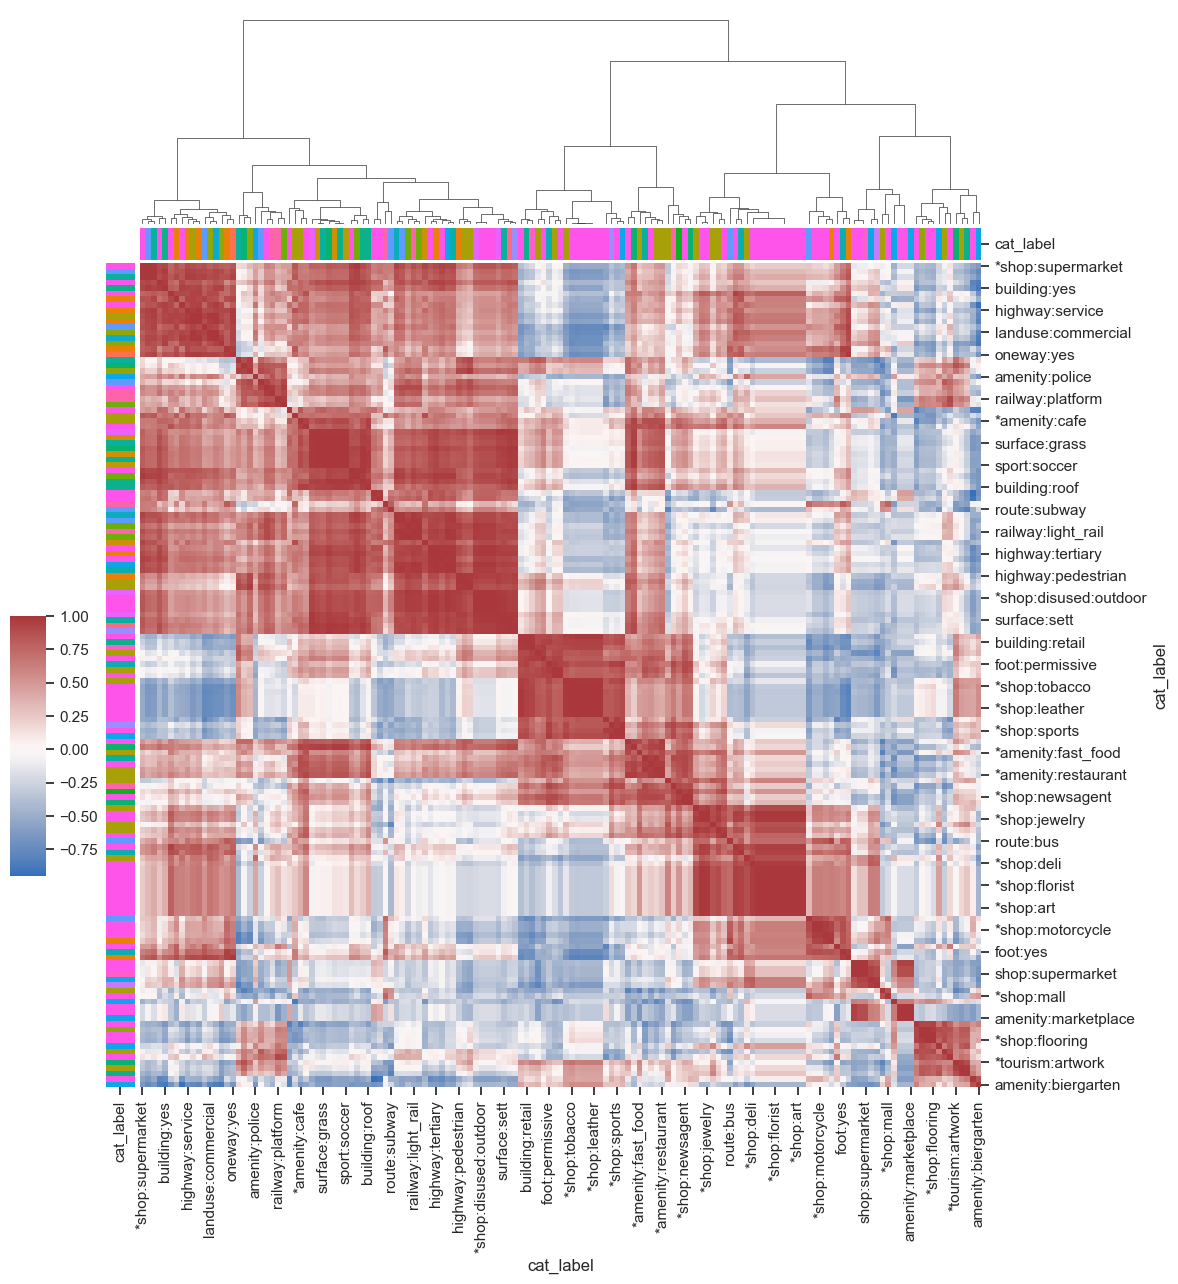

In [20]:
# Draw the full plot
g = sns.clustermap(to_cluster3.corr(), center=0, cmap="vlag",
                   method='ward',# 'average','single','complete','weighted','centroid','median','ward'
                   metric='euclidean',# 'euclidean','cityblock','cosine','correlation','hamming','jaccard','chebyshev','canberra','braycurtis','matching'
                   row_colors=row_cols, col_colors=row_cols,
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=0., figsize=(12, 13))

g.ax_row_dendrogram.remove()

In [21]:
# get clusters at desired dendrogram depth
depth = 11# no. of clusters
linkagemat = g.dendrogram_row.linkage
cluster_labels = fcluster(linkagemat, t=depth, criterion='maxclust')# Map the cluster labels to the original row labels
row_labels = pd.DataFrame(pd.Series(cluster_labels, index=to_cluster3.corr().index), columns=['cluster'])
row_cats = pd.DataFrame(row_cols).rename(columns={'day':'category'})
cats_clus = row_labels.join(row_cats).rename(columns={'cat_label':'color'}).reset_index()
cats_clus

,cat_label,cluster,color
0,*amenity:atm,8,"(0.6549693261476305, 0.625824043208658, 0.0363..."
1,*amenity:bank,6,"(0.6549693261476305, 0.625824043208658, 0.0363..."
2,*amenity:bar,7,"(0.6549693261476305, 0.625824043208658, 0.0363..."
3,*amenity:bench,5,"(0.6549693261476305, 0.625824043208658, 0.0363..."
4,*amenity:bicycle_rental,11,"(0.6549693261476305, 0.625824043208658, 0.0363..."
...,...,...,...
144,surface:paved,7,"(0.042435128078189936, 0.6869339265137814, 0.6..."
145,surface:sett,5,"(0.042435128078189936, 0.6869339265137814, 0.6..."
146,tourism:attraction,5,"(0.6033045067528132, 0.555249281081164, 0.9961..."
147,tourism:museum,6,"(0.6033045067528132, 0.555249281081164, 0.9961..."


In [22]:
# plot the contact trends in each cluster
cats_h = cats_clus.cat_label#[cats_clus.cluster==1]
to_cluster4 = to_cluster3[cats_h].stack('cat_label').reset_index().rename(columns={0:'freq'})#.groupby(['germany','match_rel']).freq.apply(np.mean)
to_cluster4['trel'] = to_cluster4.match_rel.map({'before match':0, 'during match':1, 'after match':2})
to_cluster4 = to_cluster4.merge(cats_clus[['cat_label','cluster']], on='cat_label')
to_cluster4

,germany,match_rel,cat_label,freq,trel,cluster
0,False,after match,*amenity:atm,-0.244411,2,8
1,False,before match,*amenity:atm,2.015369,0,8
2,False,during match,*amenity:atm,-0.939728,1,8
3,True,after match,*amenity:atm,-0.712742,2,8
4,True,before match,*amenity:atm,-0.549368,0,8
...,...,...,...,...,...,...
889,False,before match,work:yes,1.400407,0,1
890,False,during match,work:yes,0.059561,1,1
891,True,after match,work:yes,-0.939515,2,1
892,True,before match,work:yes,1.139816,0,1


C:\Users\steven.schulz\AppData\Local\Temp\ipykernel_13096\4071029338.py:5: UserWarning: 
The palette list has fewer values (6) than needed (149) and will cycle, which may produce an uninterpretable plot.
  sns.relplot(


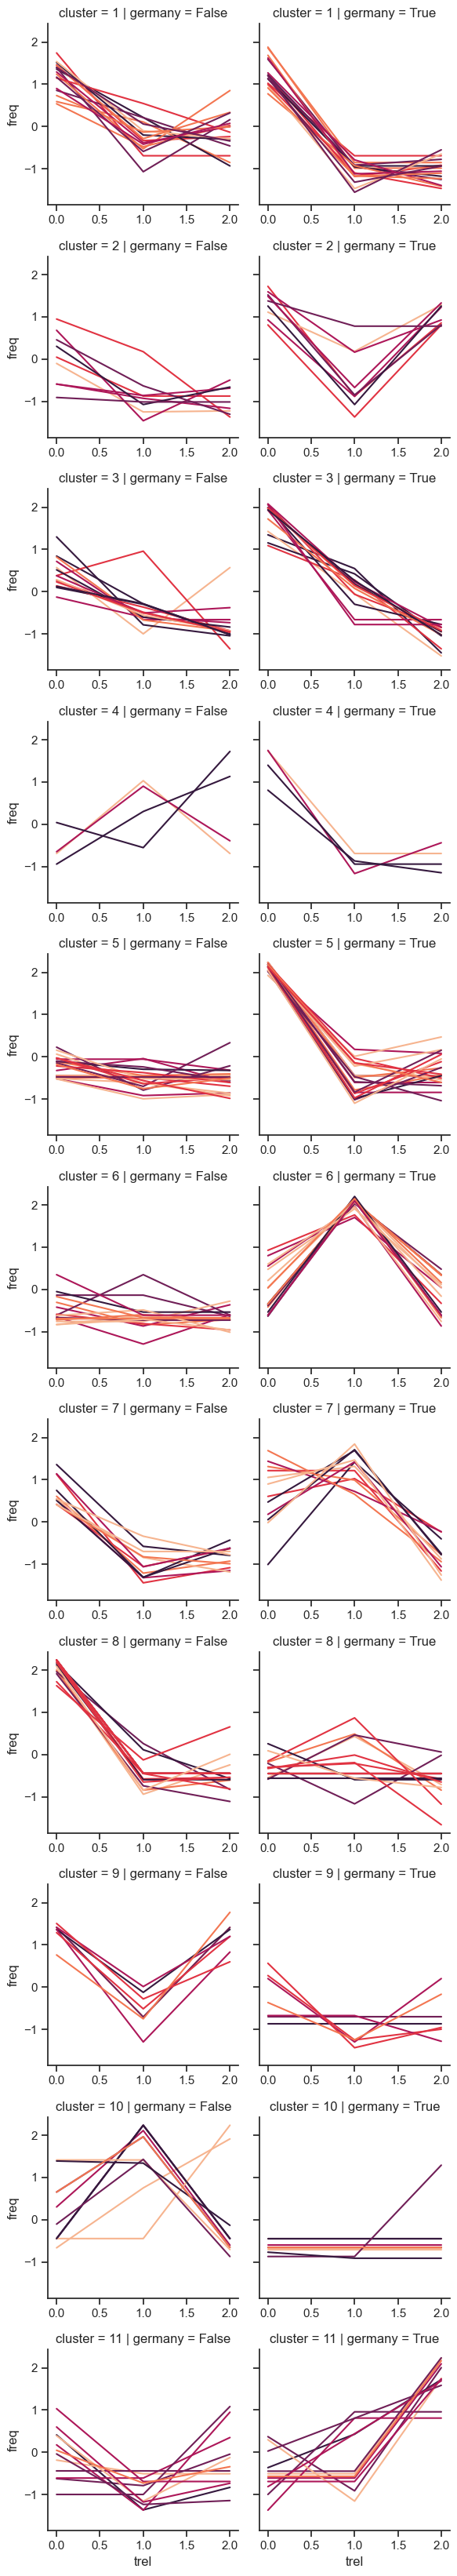

In [23]:
# Define the palette as a list to specify exact values
palette = sns.color_palette("rocket_r")

# Plot the lines on two facets
sns.relplot(
    data=to_cluster4[['germany','match_rel','freq','trel','cat_label','cluster']],
    x="trel", y="freq",
    col="germany", row="cluster", hue="cat_label",# size="cat_label",
    kind="line", size_order=["T1", "T2"], palette=palette,
    height=3, aspect=1., facet_kws=dict(sharex=False), legend=False,
)

In [24]:
for _, row in to_cluster4.groupby('cluster').cat_label.apply(list).reset_index().iterrows():
    print(row.cluster)
    print(' '.join(sorted(list(set(row.cat_label)))))
    print()

1
*amenity:taxi *shop:confectionery *shop:interior_decoration *shop:supermarket *shop:travel_agency building:yes highway:footway highway:motorway highway:primary highway:service landuse:commercial landuse:residential oneway:yes route:bicycle route:road surface:asphalt work:yes

2
*shop:dry_cleaning *tourism:information amenity:police landuse:retail railway:platform railway:rail route:light_rail service:tourism surface:fine_gravel

3
*amenity:cafe *amenity:pub *shop:books *shop:chemist *shop:electronics *tourism:viewpoint barrier:wall building:grandstand building:roof building:stadium leisure:pitch leisure:stadium service:driveway sport:soccer surface:grass

4
*shop:department_store *shop:kiosk railway:subway route:subway

5
*amenity:bench *amenity:waste_basket *shop:disused:outdoor *shop:hairdresser *shop:handbags *shop:interactive_agency *shop:shoes amenity:parking area:yes barrier:bollard barrier:fence bicycle:yes foot:designated highway:pedestrian highway:tertiary leisure:park railw

In [25]:
# colors for colorbar for clusters
#cluster_soll = 12
#cats = [cats_clus[cats_clus.cat_label==s].cluster.iloc[0]==cluster_soll for s in to_cluster3.columns.tolist()]
cats = [cats_clus[cats_clus.cat_label==s].cluster.iloc[0] for s in to_cluster3.columns.tolist()]
clist = sns.husl_palette(len(set(cats)), s=1.)
cat2col = dict(zip(list(set(cats)), clist))
row_cols2 = pd.DataFrame(cats, index=to_cluster3.columns, columns=['cat_label']).cat_label.map(cat2col)

C:\Users\steven.schulz\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\steven.schulz\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


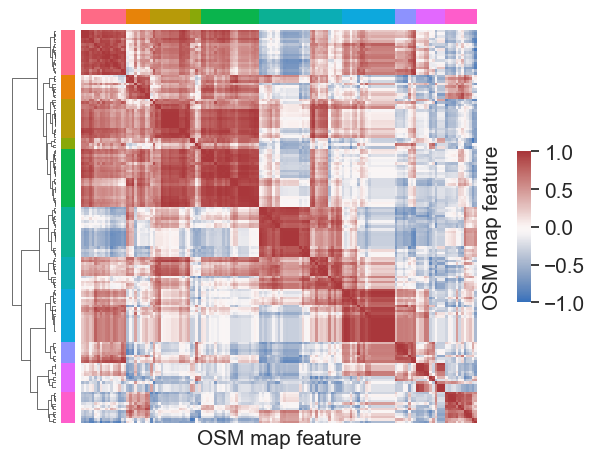

In [26]:
sns.set_theme(style="ticks")
# Draw the full plot
cnorm = TwoSlopeNorm(vmin=-1., vcenter=0., vmax=1.)
g = sns.clustermap(to_cluster3.corr(), center=0, cmap="vlag", norm=cnorm,
                   method='ward',# 'average','single','complete','weighted','centroid','median','ward'
                   metric='euclidean',# 'euclidean','cityblock','cosine','correlation','hamming','jaccard','chebyshev','canberra','braycurtis','matching'
                   row_colors=row_cols2, col_colors=row_cols2,
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.75, .445, .02, .2),#(.775, .425, .02, .2),#cbar_pos=(.02, .32, .03, .2),
                   linewidths=0., figsize=(7,7.55),# square=True, 
                  )

#g.ax_row_dendrogram.remove()
g.ax_col_dendrogram.remove()
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_xlabel('OSM map feature', fontsize=15)
g.ax_heatmap.set_ylabel('OSM map feature', fontsize=15)
g.ax_row_colors.set_xticks([])
g.ax_col_colors.set_yticks([])
g.cax.set_ylim([-1,1])
g.cax.set_yticks([-1,-.5,0,.5,1])
g.cax.tick_params(labelsize=15)

plt.savefig(f'plots/fig5/contacts_around_euro24_matches_poi_clustering.jpg', bbox_inches='tight', dpi=300)
plt.savefig(f'plots/fig5/contacts_around_euro24_matches_poi_clustering.pdf', bbox_inches='tight')
plt.show()

In [27]:
# define labels for the clusters and join them onto the data
clcm2label = {
    1:'routine & commute', 2:'travel', 3:'event venue', 4:'underground', 5:'pre-event off-venue', 6:'off-venue (1)', 7:'off-venue (2)',
    8:'suppressed (1)', 9:'suppressed (2)', 10:'home', 11:'post-event off-venue'
}
cat2clcm = to_cluster4.groupby('cluster').cat_label.apply(lambda x: list(set(x))).reset_index().explode('cat_label').rename(columns={'cluster':'cl_cm'})
cat_freq_cm = cat_freq.merge(cat2clcm, on='cat_label')
cat_freq_cm['cl_cm_label'] = cat_freq_cm.cl_cm.map(clcm2label)
cat_freq_cm

,germany,match_rel,cat,cnt,norm,freq,cat_label,cl_cm,cl_cm_label
0,False,after match,aeroway:terminal,1,9079,0.000110,aeroway:terminal,7,off-venue (2)
1,False,before match,aeroway:terminal,5,9079,0.000551,aeroway:terminal,7,off-venue (2)
2,True,before match,aeroway:terminal,1,3220,0.000311,aeroway:terminal,7,off-venue (2)
3,True,during match,aeroway:terminal,2,3220,0.000621,aeroway:terminal,7,off-venue (2)
4,False,after match,amenity:biergarten,6,9079,0.000661,amenity:biergarten,11,post-event off-venue
...,...,...,...,...,...,...,...,...,...
631,False,before match,work:yes,49,9079,0.005397,work:yes,1,routine & commute
632,False,during match,work:yes,29,9079,0.003194,work:yes,1,routine & commute
633,True,after match,work:yes,5,3220,0.001553,work:yes,1,routine & commute
634,True,before match,work:yes,16,3220,0.004969,work:yes,1,routine & commute


In [28]:
df_norm_again = cat_freq_cm[(cat_freq_cm.match_rel!='day of the match')].groupby(['germany']).cnt.sum().reset_index().rename(columns={'cnt':'norm'})
cat_freq_cm = cat_freq_cm.drop(columns=['norm']).merge(df_norm_again, on='germany')
cat_freq_cm['freq'] = cat_freq_cm.cnt / cat_freq_cm.norm
cat_freq_cm

,germany,match_rel,cat,cnt,freq,cat_label,cl_cm,cl_cm_label,norm
0,False,after match,aeroway:terminal,1,0.000085,aeroway:terminal,7,off-venue (2),11780
1,False,before match,aeroway:terminal,5,0.000424,aeroway:terminal,7,off-venue (2),11780
2,False,after match,amenity:biergarten,6,0.000509,amenity:biergarten,11,post-event off-venue,11780
3,False,after match,amenity:parking,15,0.001273,amenity:parking,5,pre-event off-venue,11780
4,False,before match,amenity:parking,22,0.001868,amenity:parking,5,pre-event off-venue,11780
...,...,...,...,...,...,...,...,...,...
631,True,before match,home:yes,14,0.001991,home:yes,10,home,7030
632,True,during match,home:yes,13,0.001849,home:yes,10,home,7030
633,True,after match,work:yes,5,0.000711,work:yes,1,routine & commute,7030
634,True,before match,work:yes,16,0.002276,work:yes,1,routine & commute,7030


In [29]:
cls_ordered_cm = ['routine & commute', 'travel', 'event venue', 'underground', 'pre-event off-venue', 'off-venue (1)', 'off-venue (2)',
    'suppressed (1)', 'suppressed (2)', 'home', 'post-event off-venue']
cats_ordered_cm = []
xclims_cm = [0]
for cl_cm in cls_ordered_cm:
    cats_ordered_cm += sorted(set(cat_freq_cm[cat_freq_cm.cl_cm_label==cl_cm].cat_label))
    xclims_cm.append(len(cats_ordered_cm))

C:\Users\steven.schulz\AppData\Local\Temp\ipykernel_13096\1833827171.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.axes.flat[-1].set_xticklabels(g.axes.flat[-1].get_xticklabels(), rotation=90)


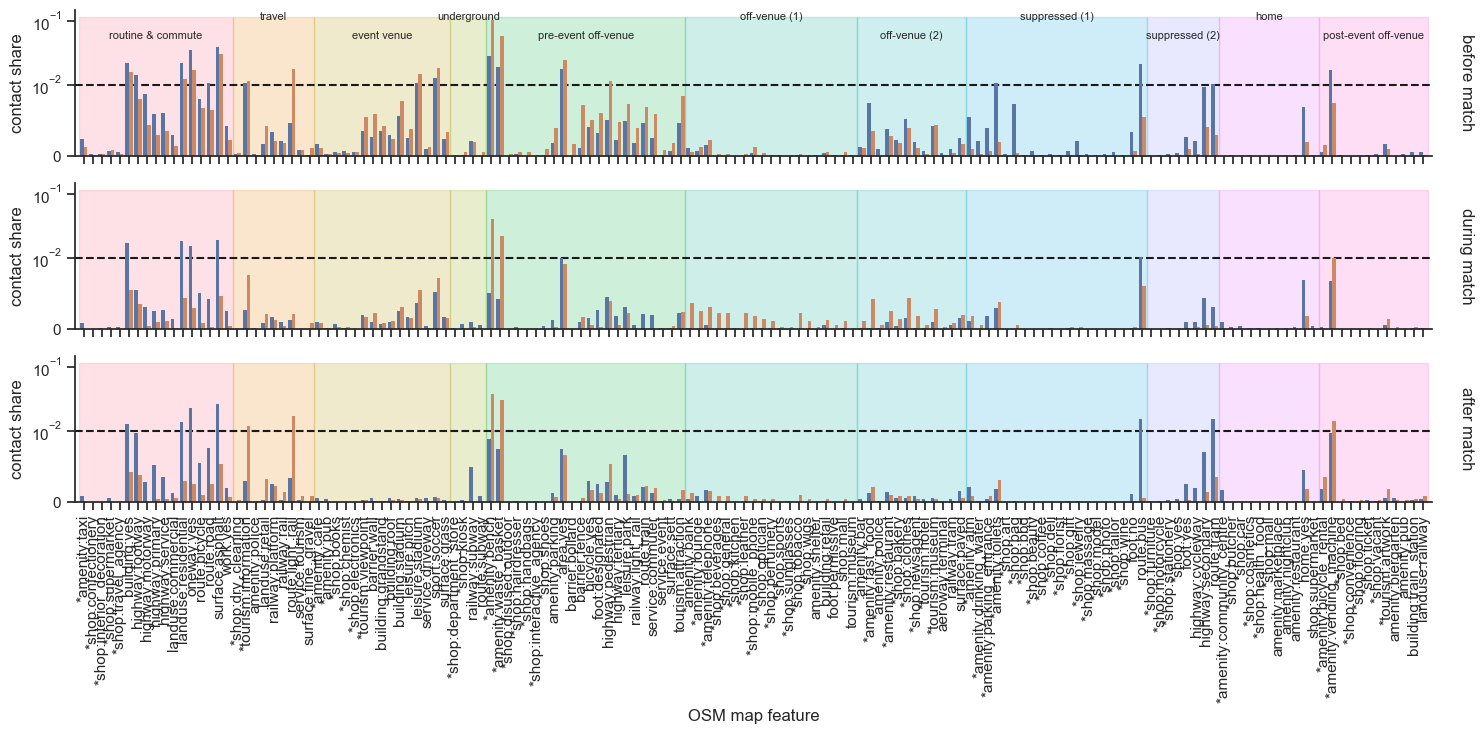

In [30]:
sns.set_theme(style="ticks")

# Create a FacetGrid, grouping by 'category'
g = sns.FacetGrid(cat_freq_cm[cat_freq_cm.match_rel!='day of the match'].sort_values(['cl_cm','cat','germany']),
                  row='match_rel', margin_titles=True, height=2.5, aspect=6,#height=2, aspect=5,# height=5, aspect=2.5,
                  row_order=['before match','during match','after match'],#,'day of the match'],
                  #col_order=['commute','attending','auxiliary','ignoring','other']
                 )

# Map the custom heatmap function to each facet
g.map_dataframe(sns.barplot, x='cat_label', y='freq', hue='germany',
                palette=sns.color_palette(None, 2), order=cats_ordered_cm, hue_order=['False','True'],
                lw=0)

# Set yticks for all subplots
g.set(xlabel='OSM map feature', ylabel='contact share')#, yticks=[])
#g.set_yticklabels([], rotation=0)
#g.set_xticklabels([], rotation=0)

# Modify margin titles
g.set_titles(row_template="{row_name}")#, col_template="{col_name}")#, size=14, fontweight='bold')
g.axes.flat[-1].set_xticklabels(g.axes.flat[-1].get_xticklabels(), rotation=90)

yu = 1.1*cat_freq_cm.freq.max()
linthresh = .01
for j, ax in enumerate(g.axes.flat):
    ax.set_yscale('symlog', linthresh=linthresh)
    ax.plot([-1.,xclims_cm[-1]], [linthresh,linthresh], c='k', ls='--', zorder=-4)
    ax.set_xlim([-1.,xclims_cm[-1]])
    for clcnt, (xl, xr, cl, c_bg) in enumerate(zip(xclims_cm[:-1], xclims_cm[1:], cls_ordered_cm, clist)):
        #alpha = .2 if clcnt%2==0 else 0.# .2
        #ax.fill_between([xl-.5, xr-.5], [yu, yu], color='gray', alpha=alpha, zorder=-5)
        ax.fill_between([xl-.5, xr-.5], [yu, yu], color=c_bg, alpha=.2, zorder=-5)
        if j==0:
            if clcnt%2==0:
                ax.text((xl+xr-1.)/2., yu/2, cl, va='center', ha='center', fontsize=8)
            else:
                ax.text((xl+xr-1.)/2., yu, cl, va='center', ha='center', fontsize=8)
#g.axes.flat[-1].tick_params(labelsize=8)

#g.add_legend(title='German participation')

g.tight_layout()
plt.savefig(f'plots/fig5/contacts_around_euro24_matches_poi_clustering2.jpg', bbox_inches='tight', dpi=300)
plt.savefig(f'plots/fig5/contacts_around_euro24_matches_poi_clustering2.pdf', bbox_inches='tight')
plt.show()

In [31]:
cat_freq[~cat_freq.cat_label.isin(cat2clcm.cat_label.tolist())]

,germany,match_rel,cat,cnt,norm,freq,cat_label
1,False,after match,shop_bool_point:yes,57,9079,0.006278,*shop_bool:yes
3,False,before match,shop_bool_point:yes,347,9079,0.038220,*shop_bool:yes
5,False,during match,shop_bool_point:yes,80,9079,0.008812,*shop_bool:yes
7,True,after match,shop_bool_point:yes,65,3220,0.020186,*shop_bool:yes
9,True,before match,shop_bool_point:yes,127,3220,0.039441,*shop_bool:yes
11,True,during match,shop_bool_point:yes,175,3220,0.054348,*shop_bool:yes


In [32]:
# map feature weights
for _, row in to_cluster4.groupby('cluster').cat_label.apply(list).reset_index().iterrows():
    print(row.cluster)
    #cat_labels_here = sorted(list(set(row.cat_label)))
    #print(' '.join(cat_labels_here))
    ws = cat_freq_cm[(cat_freq_cm.match_rel!='day of the match') & (cat_freq_cm.cl_cm==row.cluster)]
    ws = ws.groupby('cat_label').cnt.sum().reset_index().sort_values('cnt', ascending=False)
    for _, row in ws.iterrows():
        print(row.cat_label, row.cnt)
    #print(' '.join(ws.groupby('cat_label').cnt.sum().reset_index().sort_values('cnt', ascending=False).cat_label.tolist()))
    print()

1
surface:asphalt 1282
oneway:yes 1022
building:yes 795
landuse:residential 773
highway:footway 453
route:road 333
route:bicycle 277
highway:motorway 206
highway:primary 191
highway:service 180
work:yes 125
landuse:commercial 81
*amenity:taxi 57
*shop:supermarket 24
*shop:travel_agency 11
*shop:interior_decoration 7
*shop:confectionery 5

2
*tourism:information 410
route:light_rail 368
railway:platform 129
landuse:retail 101
railway:rail 64
service:tourism 25
surface:fine_gravel 21
*shop:dry_cleaning 8
amenity:police 7

3
sport:soccer 404
leisure:stadium 320
building:stadium 179
*tourism:viewpoint 120
barrier:wall 109
leisure:pitch 88
building:grandstand 87
surface:grass 86
building:roof 79
*amenity:cafe 51
service:driveway 34
*shop:books 19
*shop:chemist 15
*amenity:pub 12
*shop:electronics 10

4
railway:subway 110
route:subway 20
*shop:kiosk 18
*shop:department_store 3

5
*amenity:bench 1798
*amenity:waste_basket 1145
area:yes 700
highway:pedestrian 293
leisure:park 246
tourism:attra

In [33]:
# order clusters and remove unidentified clusters
cls_ordered_cm_red = [cl for cl in cls_ordered_cm if 'cluster ' not in cl and cl not in ['underground','routine & commute (2)','routine & commute (3)','suppressed (1)','suppressed (2)']]
# sum contact frequencies by cluster
cat_freq_cm_agg = cat_freq_cm[cat_freq_cm.cl_cm_label.isin(cls_ordered_cm_red)]\
                        .groupby(['germany','match_rel','cl_cm_label']).freq.apply(np.sum).reset_index()
cat_freq_cm_agg['trel'] = cat_freq_cm_agg.match_rel.map({'before match':0, 'during match':1, 'after match':2})
cat_freq_cm_agg['cl_cm_label'] = pd.Categorical(cat_freq_cm_agg.cl_cm_label, categories=cls_ordered_cm_red, ordered=True)
cat_freq_cm_agg

,germany,match_rel,cl_cm_label,freq,trel
0,False,after match,event venue,0.004924,2
1,False,after match,home,0.006282,2
2,False,after match,off-venue (1),0.003056,2
3,False,after match,off-venue (2),0.008065,2
4,False,after match,post-event off-venue,0.013752,2
5,False,after match,pre-event off-venue,0.046095,2
6,False,after match,routine & commute,0.114346,2
7,False,after match,travel,0.009508,2
8,False,before match,event venue,0.051188,0
9,False,before match,home,0.007470,0


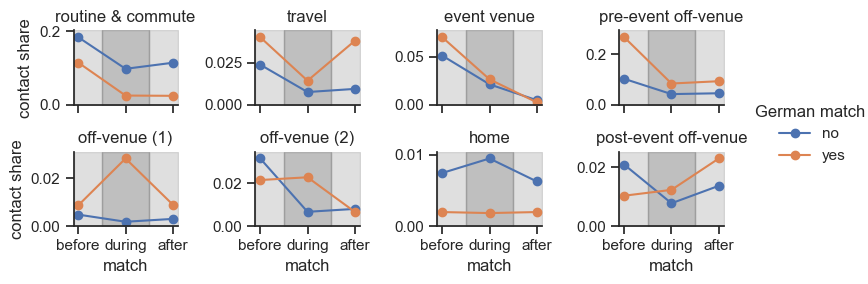

In [34]:
# Initialize a grid of plots with an Axes for each walk
ncol = 4
grid = sns.FacetGrid(cat_freq_cm_agg.sort_values(['cl_cm_label','trel']),
                     col="cl_cm_label", hue="germany", palette=sns.color_palette(), col_wrap=ncol, height=1.5, aspect=1.25,
                     sharey=False, legend_out=True)

# Draw a horizontal line to show the starting point
#grid.refline(y=0, linestyle=":")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "trel", "freq", marker="o")

# Adjust the tick positions and labels
grid.set(xticks=range(2+1), xticklabels=['before','during','after'], xlabel='match')#, ylabel='contact share')
#, yticks=[-3, 3], xlim=(-.5, 4.5), ylim=(-3.5, 3.5))

#linthresh = .01
for j, (ax, l) in enumerate(zip(grid.axes.flat, cls_ordered_cm_red)):
    yup_h = 1.1*cat_freq_cm_agg[cat_freq_cm_agg.cl_cm_label==l].freq.max()
    xl, xr = -.1, 2.1
    ax.set_ylim([0., yup_h])
    ax.set_xlim([xl, xr])
    if j%ncol==0:
        ax.set_ylabel('contact share')
    #ax.set_yscale('symlog', linthresh=linthresh)
    ax.fill_between([xl,.5], [yup_h,yup_h], color='gray', zorder=0, alpha=.25)
    ax.fill_between([.5,1.5], [yup_h,yup_h], color='gray', zorder=0, alpha=.5)
    ax.fill_between([1.5,xr], [yup_h,yup_h], color='gray', zorder=0, alpha=.25)

grid.set_titles(col_template="{col_name}")

# legend
grid.add_legend()
# Move legend to the right
grid._legend.set_bbox_to_anchor((.88, 0.5))  # (x, y)
grid._legend.set_loc("center left")  # legend aligned to the center-left of the anchor
lg = grid._legend
lg.set_title('German match ')
for tx in lg.texts:
    if tx.get_text() == 'False':
        tx.set_text('no')
    elif tx.get_text() == 'True':
        tx.set_text('yes')

# Adjust the arrangement of the plots
#grid.fig.tight_layout()#w_pad=1)
plt.savefig(f'plots/fig5/contacts_around_euro24_matches_poi_clustering3.jpg', bbox_inches='tight', dpi=300)
plt.savefig(f'plots/fig5/contacts_around_euro24_matches_poi_clustering3.pdf', bbox_inches='tight')
plt.show()

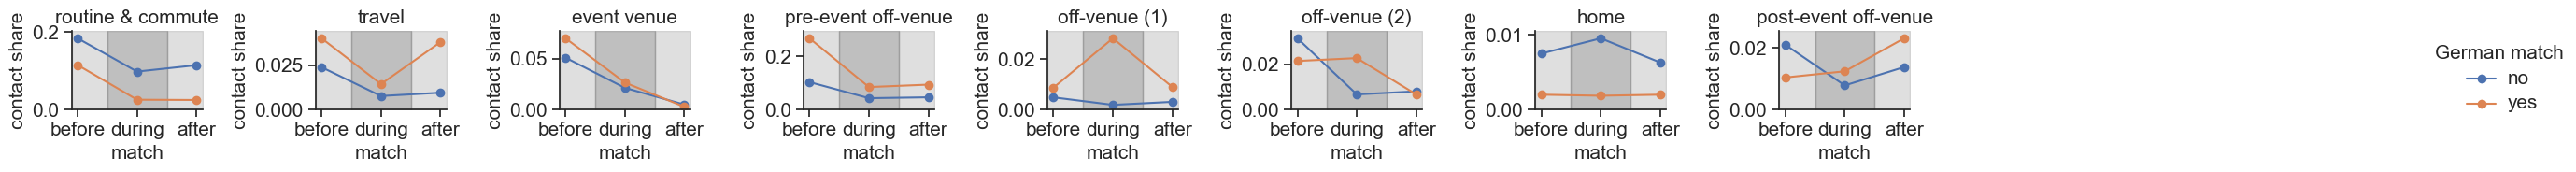

In [35]:
# Initialize a grid of plots with an Axes for each walk
ncol = 10
grid = sns.FacetGrid(cat_freq_cm_agg.sort_values(['cl_cm_label','trel']),
                     col="cl_cm_label", hue="germany", palette=sns.color_palette(), col_wrap=ncol, height=2., aspect=1.25,
                     sharey=False, legend_out=True)

# Draw a horizontal line to show the starting point
#grid.refline(y=0, linestyle=":")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "trel", "freq", marker="o")

# Adjust the tick positions and labels
grid.set(xticks=range(2+1), xticklabels=['before','during','after'], xlabel='match')#, ylabel='contact share')
#, yticks=[-3, 3], xlim=(-.5, 4.5), ylim=(-3.5, 3.5))

#linthresh = .01
for j, (ax, l) in enumerate(zip(grid.axes.flat, cls_ordered_cm_red)):
    yup_h = 1.1*cat_freq_cm_agg[cat_freq_cm_agg.cl_cm_label==l].freq.max()
    xl, xr = -.1, 2.1
    ax.set_ylim([0., yup_h])
    ax.set_xlim([xl, xr])
    if True:#j%ncol==0:
        ax.set_ylabel('contact share', fontsize=15)
        ax.set_xlabel('match', fontsize=15)
        ax.tick_params(axis='both', labelsize=15)
    #ax.set_yscale('symlog', linthresh=linthresh)
    ax.fill_between([xl,.5], [yup_h,yup_h], color='gray', zorder=0, alpha=.25)
    ax.fill_between([.5,1.5], [yup_h,yup_h], color='gray', zorder=0, alpha=.5)
    ax.fill_between([1.5,xr], [yup_h,yup_h], color='gray', zorder=0, alpha=.25)

grid.set_titles(col_template="{col_name}", size=15)

# legend
grid.add_legend()
# Move legend to the right
grid._legend.set_bbox_to_anchor((1., 0.5))  # (x, y)
grid._legend.set_loc("center left")  # legend aligned to the center-left of the anchor
lg = grid._legend
lg.set_title('German match ')
for tx in lg.texts:
    if tx.get_text() == 'False':
        tx.set_text('no')
    elif tx.get_text() == 'True':
        tx.set_text('yes')

for ax in grid.axes.flat:
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(['before','during','after'], fontsize=15)

leg = grid._legend#g.add_legend(fontsize=15, title_fontsize=15)
# Change legend fontsize
for text in leg.texts:
    text.set_fontsize(15)          # legend labels
leg.get_title().set_fontsize(15)   # legend title fontsize
#leg.set_frame_on(True)
#leg.get_frame().set_alpha(1.)
#leg.get_frame().set_facecolor('white')
#leg.get_frame().set_linewidth(0.)

# Adjust the arrangement of the plots
grid.fig.tight_layout()#w_pad=1)
plt.savefig(f'plots/fig5/contacts_around_euro24_matches_poi_clustering6.jpg', bbox_inches='tight', dpi=300)
plt.savefig(f'plots/fig5/contacts_around_euro24_matches_poi_clustering6.pdf', bbox_inches='tight')
plt.show()

In [36]:
# should sum to one, unless some clusters are excluded
cat_freq_cm_agg.groupby(['germany']).freq.sum()

germany
False    0.828014
True     0.950640
Name: freq, dtype: float64

In [37]:
cat_freq_cm_agg_cmpl = cat_freq_cm.groupby(['germany','match_rel','cl_cm_label']).freq.apply(np.sum).reset_index()
# should sum to one
cat_freq_cm_agg_cmpl.groupby(['germany']).freq.sum()

germany
False    1.0
True     1.0
Name: freq, dtype: float64

## examples of contacts mapped to OSM tags

In [186]:
cat_ex = cats_clus[cats_clus.cat_label.isin(['route:light_rail','leisure:stadium','*amenity:fast_food'])].copy(deep=True)
cat_ex['cl_cm_label'] = cat_ex.cluster.map(clcm2label)
cat_ex

,cat_label,cluster,color,cl_cm_label
8,*amenity:fast_food,7,"(0.789110415284255, 0.5752001137455897, 0.0366...",city
119,leisure:stadium,3,"(0.2629275039965128, 0.6998079504909376, 0.035...",stadium
128,route:light_rail,2,"(0.9971113841978364, 0.4171594688458531, 0.526...",rail


In [1020]:
set(data_osm2[(data_osm2.route=='light_rail') & (data_osm2.match_rel=='before match') & (data_osm2.city=='Stuttgart')].tl)

{579593100010,
 597401220230,
 601852230010,
 601852230320,
 601852232100,
 601853223100,
 606290320100,
 606290320200,
 610731110200,
 610731231130,
 619560330200}

In [1021]:
set(data_osm2[(data_osm2.amenity=='parking') & (data_osm2.match_rel=='before match') & (data_osm2.city=='Stuttgart')].tl)

{592971020130,
 610751303310,
 610751303330,
 610751312030,
 610751312200,
 610751312220,
 610751312300}

In [1022]:
set(data_osm2[(data_osm2.barrier=='fence') & (data_osm2.match_rel=='before match') & (data_osm2.city=='Stuttgart')].tl)

{606302322320,
 610731231130,
 610750030110,
 610750030300,
 610751330230,
 610751332010,
 610760213200,
 615171210030}

In [1025]:
set(data_osm2[(data_osm2.leisure=='stadium') & (data_osm2.match_rel=='before match') & (data_osm2.city=='Stuttgart')].tl)

{610751313130,
 610751313220,
 610751313310,
 610751313320,
 610751330300,
 610751330310,
 610751330320,
 610751331000,
 610751331010,
 610751331210,
 610751331310,
 610751331320,
 610751331330,
 610751333110,
 610760200330,
 610760201230,
 610760201320,
 610760202020,
 610760202030,
 610760202110,
 610760202200,
 610760203000,
 610760222020,
 610760222130,
 610760222200,
 610760222210,
 610760222220,
 610760222230,
 610760222320,
 610760223020,
 610760223030,
 610760223200,
 610760230100}

In [1034]:
set(data_osmpoint2[(data_osmpoint2.amenity_point=='fast_food') & (data_osmpoint2.match_rel=='during match') & (data_osmpoint2.city=='Stuttgart')].tl)

{601852203230, 601852203320, 601852221130, 601852232010}

- `route='light_rail'`: 579593100010 (far from stadium)
- `amenity='parking'`: 610751303310 (near stadium)
- `leisure='stadium'`: 6107513132(20) (inside stadium)
- `amenity='fast_food'`: 601852203230 (city center)

code to visualize contacts with polygons:
```
with t2osm as (
	select t2o.tile_id, tile, unnest(osm_ids) as osm_id
		, st_transform(st_translate(st_setsrid(tile6togeo(t2o.tile), 32632), tx.minx, tx.miny), 3857) as geopoint_t2o
		, st_transform(st_translate(st_setsrid(tile8togeo(610751313220), 32632), tx.minx, tx.miny), 3857) as geopoint_c
	from tuberlin_euro2024_tile2osmid as t2o
	join txc_dt_grid_1000m as tx on t2o.tile_id = tx.tile_id
	where tile = 6107513132
)
select osm.way, tile82polygon(t2osm.geopoint_c), t2osm.*
from t2osm
join tuberlin_euro2024_osm as osm on osm.osm_id = t2osm.osm_id and osm.tile_id = t2osm.tile_id
where osm.leisure='stadium'--osm.barrier='wall'--osm.amenity='parking'--osm.route='light_rail'
```

code to visualize contacts with points:
```
with t2osm as (
	select t2o.tile_id, tile, unnest(osm_ids) as osm_id
		, st_transform(st_translate(st_setsrid(tile6togeo(t2o.tile), 32632), tx.minx, tx.miny), 3857) as geopoint_t2o
		, st_transform(st_translate(st_setsrid(tile8togeo(601852203230), 32632), tx.minx, tx.miny), 3857) as geopoint_c
	from tuberlin_euro2024_tile2osmid as t2o
	join txc_dt_grid_1000m as tx on t2o.tile_id = tx.tile_id
	where tile = 601852203230
)
select poi.way_point, tile82polygon(t2osm.geopoint_c), poi.way_polygon, t2osm.*
from t2osm
join euro2024_poi_all_smallestpolygon as poi on poi.osm_id_polygon = t2osm.osm_id
--where poi.amenity='fast_food'
```